In [1]:
import numpy as np
import dpmm
import matplotlib.pyplot as plt
%matplotlib inline

/Users/josh/miniconda2/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


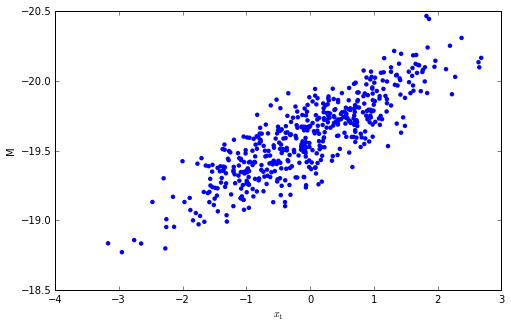

Uncorrected dispersion:  0.287475751204
Corrected dispersion:  0.15


In [2]:
# First simulate some SNe on the Phillips relation.
SN_alpha = -0.25
x1s = np.random.normal(scale=1.0, size=500)
Ms = -19.6 + x1s * SN_alpha + np.random.normal(scale=0.15, size=500)

f = plt.figure(figsize=(8, 5))
ax = f.add_subplot(111)
ax.scatter(x1s, Ms)
ax.set_ylim(-18.5, -20.5)
ax.set_xlabel("$x_1$")
ax.set_ylabel("M")
plt.show()

print "Uncorrected dispersion: ", np.std(Ms)
print "Corrected dispersion: ", 0.15

In [3]:
# Create a Dirichlet Process Mixture Model.  Use a Normal-Inverse-Wishart prior, which models the mean
# and covariance matrix of an N-dimensional Gaussian.
mu_0 = np.r_[0.0, -19.6]
kappa_0 = 1.1
Lam_0 = np.eye(2)*0.3
nu_0 = 2

dp_alpha = 0.01 # Dirichlet Process clustering parameter.  Set higher to infer more components, lower to infer fewer.
cp = dpmm.NormInvWish(mu_0, kappa_0, Lam_0, nu_0)
data = np.dstack([x1s, Ms])[0]
dp = dpmm.DPMM(cp, dp_alpha, data)

In [4]:
dp.update(100)

In [5]:
# Sample
phis = []
nphis = []
# Sample
for i in xrange(10):
    dp.update(10)
    phis.append(list(dp.phi)) # Use list() to get a copy
    nphis.append(list(dp.nphi))

In [6]:
# Modified code from http://stackoverflow.com/questions/9081553/python-scatter-plot-size-and-style-of-the-marker/24567352#24567352

def ellipses(x, y, s, q, pa, c='b', ax=None, vmin=None, vmax=None, **kwargs):
    """Scatter plot of ellipses.
    
    (x, y) duh.
    s      size.
    q      minor-to-major axes ratio b/a
    pa     position angle CCW in deg.
    """
    from matplotlib.patches import Ellipse
    from matplotlib.collections import PatchCollection
    import pylab as plt
    #import matplotlib.colors as colors

    if ax is None:
        ax = plt.gca()    

    if isinstance(c,basestring):
        color = c     # ie. use colors.colorConverter.to_rgba_array(c)
    else:
        color = None  # use cmap, norm after collection is created
    kwargs.update(color=color)

    w, h = s*np.sqrt(q), s/np.sqrt(q)
    
    if np.isscalar(x):
        patches = [Ellipse((x, y), w, h, pa),]
    else:
        patches = [Ellipse((x_,y_), w_, h_, pa_) for x_,y_,w_,h_,pa_ in zip(x,y,w,h,pa)]
    collection = PatchCollection(patches, **kwargs)

    if color is None:
        collection.set_array(np.asarray(c))
        if vmin is not None or vmax is not None:
            collection.set_clim(vmin, vmax)

    ax.add_collection(collection)
    ax.autoscale_view()
    return collection    

In [31]:
def plot_sample(phi, nphi, axis=None, **kwargs):
    if axis is None:
        axis = plt.gca()
    for ph, n in zip(phi, nphi):
        val, vec = np.linalg.eigh(ph[1])
        # 5.991 gives 95% ellipses
        s = np.sqrt(np.sqrt(5.991*val[0]*val[1]))
        q = np.sqrt(val[0]/val[1])
        pa = -np.arctan2(vec[0,0], vec[0,1])*180/np.pi
        ellipses(ph[0][0], ph[0][1], s, q, pa, **kwargs)

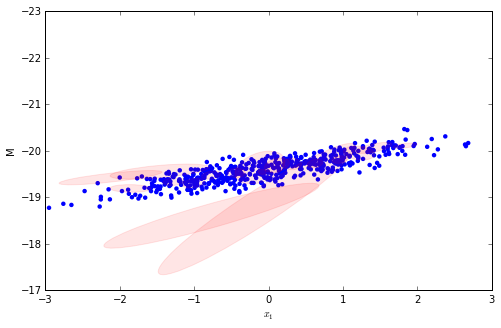

In [40]:
f = plt.figure(figsize=(8, 5))
ax = f.add_subplot(111)
ax.scatter(x1s, Ms)
ax.set_ylim(-17, -23)
ax.set_xlim(-3,3)
ax.set_xlabel("$x_1$")
ax.set_ylabel("M")

for phi, nphi in zip(phis, nphis)[7:8]:
    plot_sample(phi, nphi, axis=ax, c='r', alpha=0.1)

plt.show()

In [9]:
# Given the dp samples, what is the conditional probability given x1=0?
def make_gmm(phi, nphi):
    proportions = np.array(nphi)*1.0/np.sum(nphi)
    components = [dpmm.GaussND(mu, Sig) for mu, Sig in phi]
    return dpmm.GMM(components, proportions)

In [10]:
g = make_gmm(phis[0], nphis[0])

In [11]:
gc0 = g.cond([0, None])
gc1 = g.cond([1, None])
gcm1 = g.cond([-1, None])

In [12]:
x = np.linspace(-18, -21, 100)
ym1 = np.zeros_like(x)
y0 = np.zeros_like(x)
y1 = np.zeros_like(x)
for phi, nphi in zip(phis, nphis):
    g = make_gmm(phis[0], nphis[0])

    gcm1 = g.cond([-1, None])
    gc0 = g.cond([0, None])
    gc1 = g.cond([1, None])

    ym1 += np.array([gcm1(x_)[0,0] for x_ in x])
    y0 += np.array([gc0(x_)[0,0] for x_ in x])
    y1 += np.array([gc1(x_)[0,0] for x_ in x])

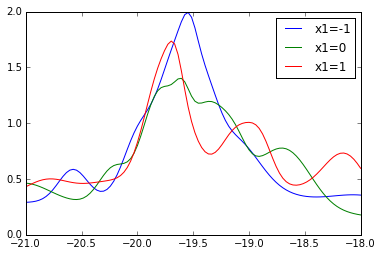

In [13]:
plt.plot(x, ym1, label='x1=-1')
plt.plot(x, y0, label='x1=0')
plt.plot(x, y1, label='x1=1')
plt.legend()

In [14]:
print np.sum((x[0]-x[1])*y0)

2.16280627738


In [18]:
print np.sum((x[0]-x[1])*x*y0) / 2.1628

-19.4996296744


In [19]:
print np.sum((x[0]-x[1])*(x+19.49963)**2*y0) / 2.1628

0.467851618679


In [20]:
print np.sqrt(0.46)

0.678232998313


In [24]:
[len(nphi) for nphi in nphis]

[24, 17, 23, 22, 19, 22, 24, 18, 24, 23]